In [1]:
def sarsa(env, ep, gamma, alpha, eps):
    """Sarsa (on-policy TD control)

    Params:
        env - environment
        ep - number of episodes to run
        gamma - discount factor [0..1]
        alpha - step size (0..1]
        eps - epsilon-greedy param
    """
    def policy(st, Q, eps):
        if np.random.rand() > eps:
            return argmax_rand([Q[st,a] for a in env.act_space])
        else:
            return np.random.choice(env.act_space)

    Q = defaultdict(float)  # default zero for all, terminal MUST be zero

    for _ in range(ep):
        S = env.reset()
        A = policy(S, Q, eps)
        while True:
            S_, R, done = env.step(A)
            A_ = policy(S_, Q, eps)
            Q[S,A] = Q[S,A] + alpha * (R + gamma * Q[S_,A_] - Q[S,A])
            S, A = S_, A_
            if done: break

    return Q

In [2]:
def argmax_rand(arr):
    # break ties randomly, np.argmax() always picks first max
    return np.random.choice(np.flatnonzero(arr == np.max(arr)))

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from helpers_0604 import plot_windy

In [5]:
class WindyGridworld:
    def __init__(self):
        self.act_space = [0, 1, 2, 3]  # LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3
        self.reset()

    def reset(self):
        self._x, self._y = 0, 3        # agent initial position
        return (0, 3)

    def step(self, action):
        # actions: LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3
        self._x, self._y = self.transition(self._x, self._y, action)

        if self._x == 7 and self._y == 3:        # GOAL reached
            return (self._x, self._y), -1, True  # observation, reward, done
        return (self._x, self._y), -1, False     # obs, rew, done

    def transition(self, x, y, action):
        """Perform transition from [x,y] given action"""

        if x in [3,4,5,8]:  y += 1    # windy
        if x in [6,7]:      y += 2    # woo, very windy

        if action == 0:    x -= 1     # left
        elif action == 1:  y -= 1     # down
        elif action == 2:  x += 1     # right
        elif action == 3:  y += 1     # up
        else: raise ValueError('Action must be in [0,1,2,3]')

        x = np.clip(x, 0, 9)   # x range is [0..9]
        y = np.clip(y, 0, 6)   # y range is [0..6]
        return x, y

    def get_path(self, Q):
        x, y = 0, 3       # agent starting position
        path = [(x, y)]   # save starting position
        for _ in range(100):  # limit steps in case policy is loopy
            A_star = np.argmax([Q[(x,y),a] for a in [0, 1, 2, 3]])   # pick best action
            x, y = self.transition(x, y, A_star)         # take one step
            path.append((x,y))                            # save to path
            if x == 7 and y == 3:  break                 # if goal: break
        return path

In [6]:
env = WindyGridworld()


In [7]:
Q = sarsa(env, 10000, gamma=1., alpha=.5, eps=.1)


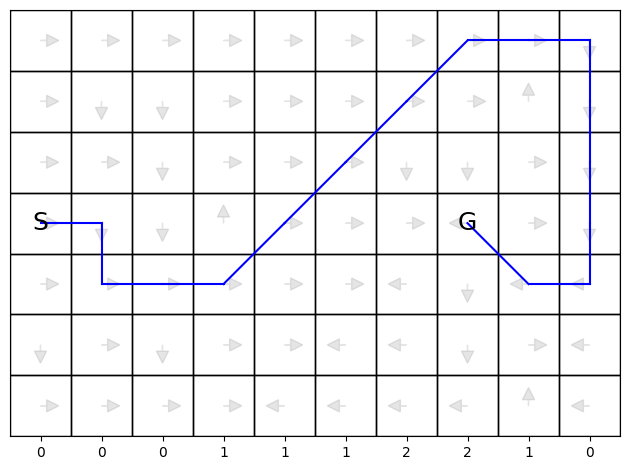

In [8]:
optimal_path = env.get_path(Q)
plot_windy(Q, optimal_path)

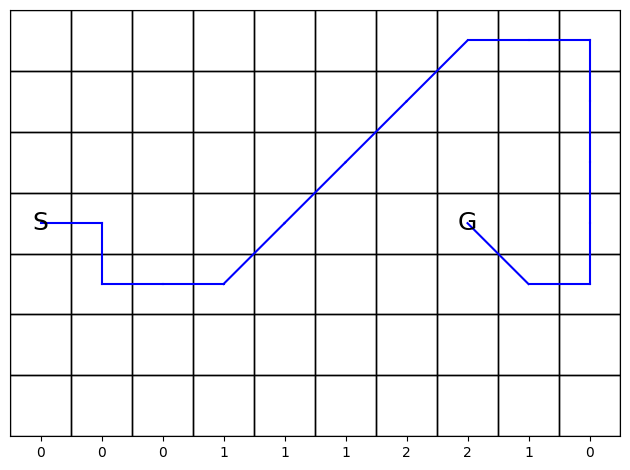

In [9]:
plot_windy(Q=None, path=optimal_path, saveimg=None)

In [10]:
def sarsa_ext(env, ep, gamma, alpha, eps, max_time_steps=None):
    def policy(st, Q, eps):
        if np.random.rand() > eps:
            return argmax_rand([Q[st,a] for a in env.act_space])
        else:
            return np.random.choice(env.act_space)

    hist_ep = []   # current episode nb saved on each time step

    Q = defaultdict(float)  # default zero for all, terminal MUST be zero

    for current_episode in range(ep):
        S = env.reset()
        A = policy(S, Q, eps)
        while True:
            S_, R, done = env.step(A)
            A_ = policy(S_, Q, eps)
            Q[S,A] = Q[S,A] + alpha * (R + gamma * Q[S_,A_] - Q[S,A])
            S, A = S_, A_

            # Change! keep track of episode number history
            hist_ep.append(current_episode)
            if max_time_steps is not None:
                if len(hist_ep) >= max_time_steps:
                    return Q, hist_ep

            if done: break

    return Q, hist_ep

In [11]:
Q, hist_ep = sarsa_ext(env, 10000, gamma=1., alpha=.5, eps=.1, max_time_steps=8000)


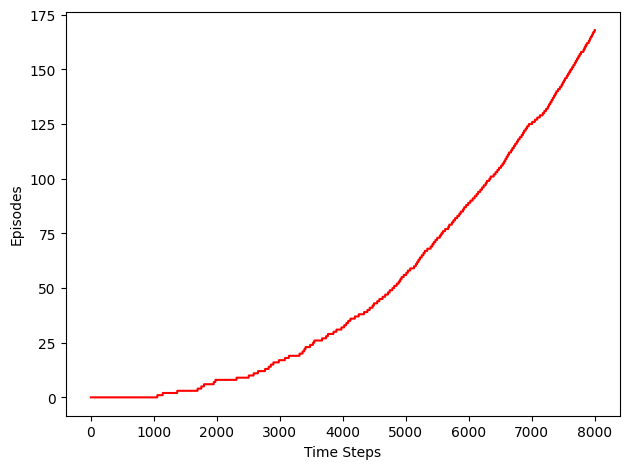

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(hist_ep, color='red')
ax.set_xlabel('Time Steps')
ax.set_ylabel('Episodes')
plt.tight_layout()
plt.show()